# Bidirectional Scan Phase Correction
Based on Yao's FixScanPhaseMismatchOfStack_SineWave.m

In [44]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from skimage.registration import phase_cross_correlation
import tifffile
%matplotlib inline

In [45]:
inpath = Path.home() / 'Documents/data/yao'
tif_files = sorted(inpath.glob('*.tif'))
original_tif = [f for f in tif_files if 'corrected' not in f.name.lower()][0]
data = tifffile.imread(original_tif)
frame = np.mean(data.mean(axis=0), axis=0)
print(f'{original_tif.name}: {frame.shape}')

20251113-BrainSlice-5.3mW_cavityB_Bead3_Region6_depth-5-35um-Zoom2-Stack_00001.tif: (512, 512)


In [46]:
def measure_shifts(frame, window_size=64, stride=24, upsample=10, min_percentile=55, max_shift=10):
    pre, post = frame[::2], frame[1::2]
    m = min(pre.shape[0], post.shape[0])
    a, b = pre[:m], post[:m]
    h, w = a.shape
    thresh = np.percentile(frame, min_percentile)
    x_pos, y_pos, shifts, intensities = [], [], [], []
    
    for y in range(0, h - window_size, stride):
        for x in range(0, w - window_size, stride):
            win_a = a[y:y+window_size, x:x+window_size]
            win_b = b[y:y+window_size, x:x+window_size]
            mean_int = (win_a.mean() + win_b.mean()) / 2
            if mean_int < thresh:
                continue
            try:
                shift_2d, _, _ = phase_cross_correlation(win_a, win_b, 
                                                         upsample_factor=upsample, normalization=None)
                h_shift = float(shift_2d[1])
                if abs(h_shift) <= max_shift:
                    x_pos.append(x + window_size // 2)
                    y_pos.append(2 * (y + window_size // 2))  # Convert to frame coords
                    shifts.append(h_shift)
                    intensities.append(mean_int)
            except:
                continue
    
    return np.array(x_pos), np.array(y_pos), np.array(shifts), np.array(intensities)

x_pos, y_pos, shifts, intensities = measure_shifts(frame)
print(f'Measurements: {len(shifts)}, range: [{shifts.min():.2f}, {shifts.max():.2f}] px')

Measurements: 95, range: [-1.10, 6.20] px


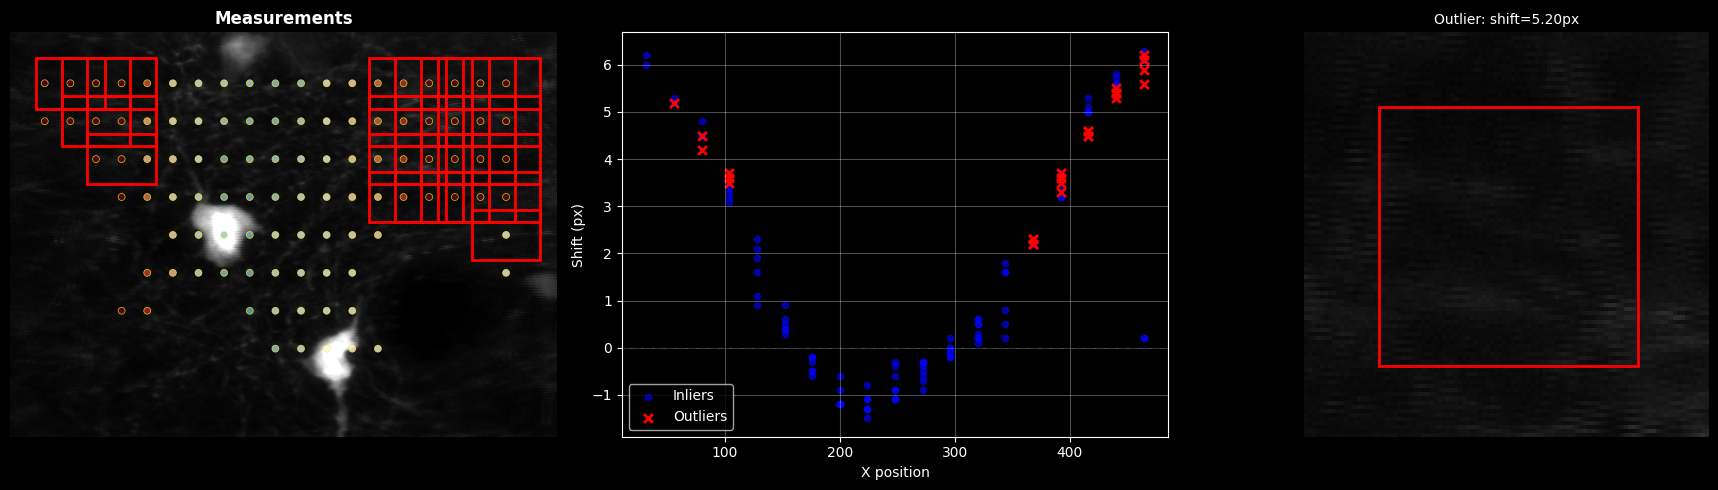

In [47]:
# Visualize measurements and outliers
# Make sure mask matches current data
if len(outlier_mask) != len(x_pos):
    print(f'WARNING: Mask mismatch, recalculating outliers')
    median_shift = np.median(shifts)
    mad = np.median(np.abs(shifts - median_shift))
    outlier_mask = np.abs(shifts - median_shift) > 3 * mad

n_plots = 3 if outlier_mask.sum() > 0 else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
if n_plots == 2:
    axes = [axes[0], axes[1]]
vmin, vmax = np.percentile(frame, [1, 99.5])

# Full image
axes[0].imshow(frame, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto')
axes[0].scatter(x_clean, y_clean, c=shifts_clean, s=25, cmap='RdBu_r', vmin=-3, vmax=3, 
               edgecolors='yellow', linewidth=0.5, alpha=0.8)
if outlier_mask.sum() > 0:
    for x_out, y_out in zip(x_pos[outlier_mask], y_pos[outlier_mask]):
        axes[0].add_patch(Rectangle((x_out-32, y_out-32), 64, 64, 
                                    edgecolor='red', facecolor='none', linewidth=2))
axes[0].set_title('Measurements', fontsize=12, weight='bold')
axes[0].axis('off')

# Scatter
axes[1].scatter(x_clean, shifts_clean, c='blue', s=20, alpha=0.6, label='Inliers')
if outlier_mask.sum() > 0:
    axes[1].scatter(x_pos[outlier_mask], shifts[outlier_mask], c='red', s=40, 
                   marker='x', linewidths=2, label='Outliers')
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1].set_xlabel('X position')
axes[1].set_ylabel('Shift (px)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Zoom
if outlier_mask.sum() > 0:
    x_out, y_out = x_pos[outlier_mask][0], y_pos[outlier_mask][0]
    zoom_size = 100
    x_start = max(0, int(x_out - zoom_size//2))
    y_start = max(0, int(y_out - zoom_size//2))
    zoom = frame[y_start:y_start+zoom_size, x_start:x_start+zoom_size]
    axes[2].imshow(zoom, cmap='gray', vmin=vmin, vmax=vmax)
    rect_x = x_out - x_start - 32
    rect_y = y_out - y_start - 32
    axes[2].add_patch(Rectangle((rect_x, rect_y), 64, 64, 
                                edgecolor='red', facecolor='none', linewidth=2))
    axes[2].set_title(f'Outlier: shift={shifts[outlier_mask][0]:.2f}px', fontsize=10)
    axes[2].axis('off')

plt.tight_layout()

Outliers mess this up

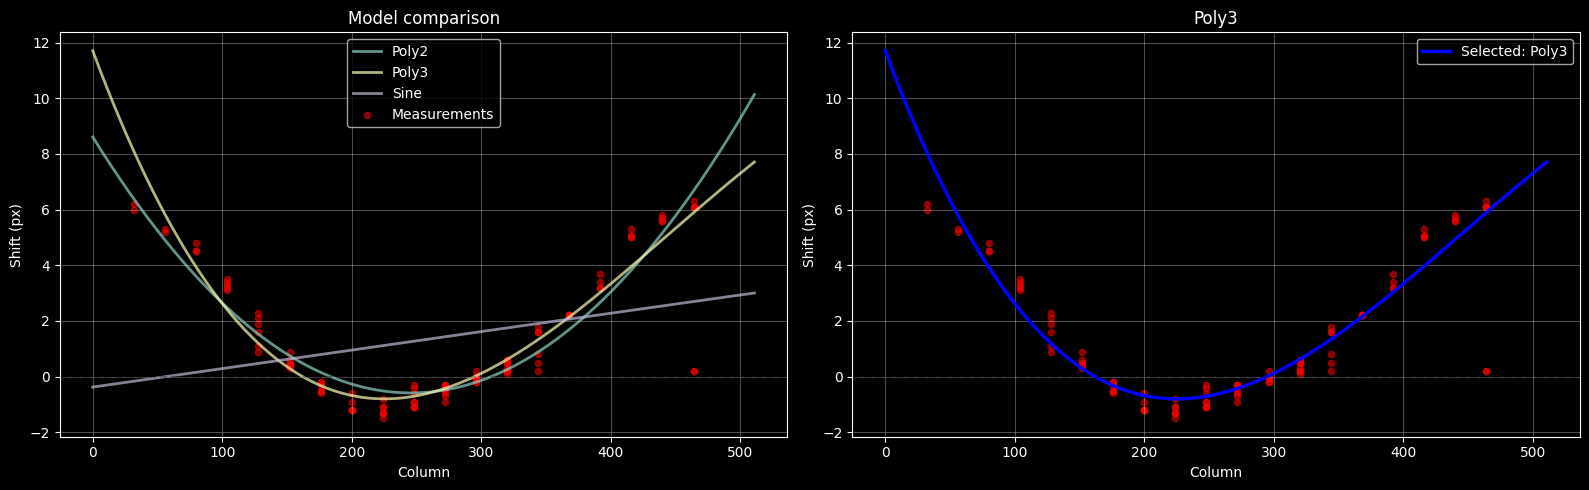

In [48]:
# Plot all models
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(dx_poly2, linewidth=2, label='Poly2', alpha=0.7)
axes[0].plot(dx_poly3, linewidth=2, label='Poly3', alpha=0.7)
if sine_ok:
    axes[0].plot(dx_sine, linewidth=2, label='Sine', alpha=0.7)
axes[0].scatter(x_clean, shifts_clean, c='red', s=20, alpha=0.5, label='Measurements')
axes[0].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Shift (px)')
axes[0].set_title('Model comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(dx_col, linewidth=2.5, label=f'Selected: {model}', color='blue')
axes[1].scatter(x_clean, shifts_clean, c='red', s=20, alpha=0.5)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Shift (px)')
axes[1].set_title(f'{model}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

In [53]:
# Optional: zero center
use_zero_center = True  # Turn off for now - let polynomial handle it
if use_zero_center:
    dx_col[130:385] = 0
    print(f'Zeroed center, range: [{dx_col.min():.2f}, {dx_col.max():.2f}] px')
else:
    print(f'Using full correction, range: [{dx_col.min():.2f}, {dx_col.max():.2f}] px')

Zeroed center, range: [0.00, 11.71] px


In [54]:
def apply_bidir_correction(I, dx_col):
    nr, nc = I.shape
    currentSlice = I.copy()
    currentSlice[1::2, :] = np.fliplr(currentSlice[1::2, :])
    even = currentSlice[1::2, :]
    m, even_corr = even.shape[0], np.zeros_like(even)
    x, x_src = np.arange(nc), np.arange(nc) - dx_col
    
    for r in range(m):
        F = interp1d(x, even[r, :], kind='linear', bounds_error=False, fill_value='extrapolate')
        even_corr[r, :] = F(x_src)
    
    Icorr = currentSlice.copy()
    Icorr[1::2, :] = even_corr
    currentSlice[1::2, :] = np.fliplr(currentSlice[1::2, :])
    Icorr[1::2, :] = np.fliplr(Icorr[1::2, :])
    return Icorr

corrected = apply_bidir_correction(frame, dx_col)
print('Corrected')

Corrected


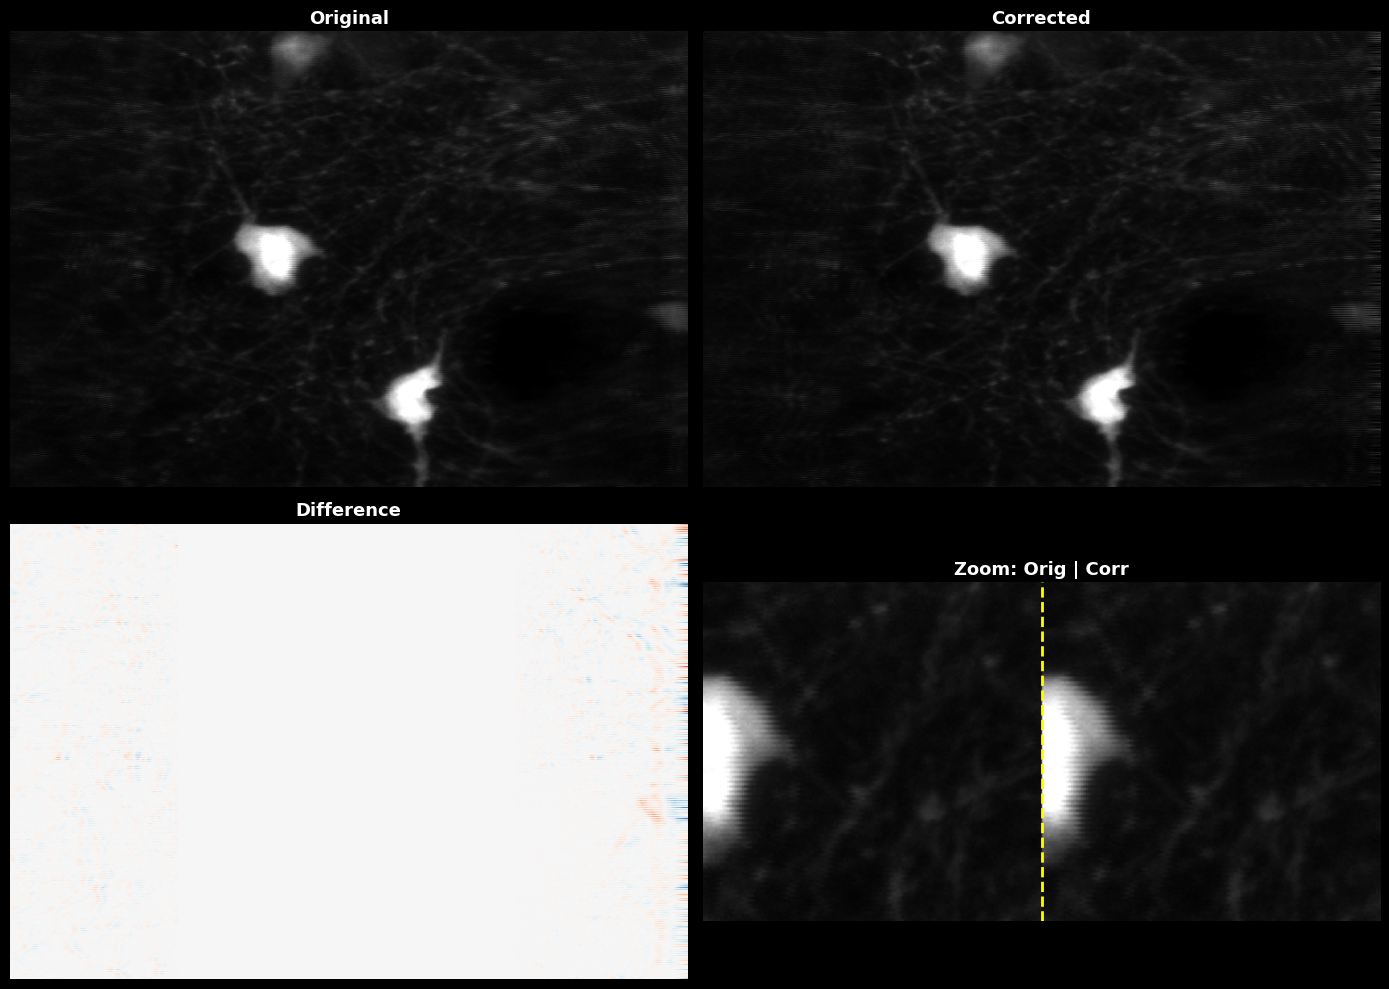

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
vmin, vmax = np.percentile(frame, [1, 99.5])

axes[0, 0].imshow(frame, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto')
axes[0, 0].set_title('Original', fontsize=13, weight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(corrected, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto')
axes[0, 1].set_title('Corrected', fontsize=13, weight='bold')
axes[0, 1].axis('off')

diff = corrected - frame
axes[1, 0].imshow(diff, cmap='RdBu_r', vmin=-300, vmax=300, aspect='auto')
axes[1, 0].set_title('Difference', fontsize=13, weight='bold')
axes[1, 0].axis('off')

y, x, size = 180, 200, 140
zoom_orig = frame[y:y+size, x:x+size]
zoom_corr = corrected[y:y+size, x:x+size]
combined = np.hstack([zoom_orig, zoom_corr])
axes[1, 1].imshow(combined, cmap='gray', vmin=vmin, vmax=vmax)
axes[1, 1].axvline(size, color='yellow', linestyle='--', linewidth=2)
axes[1, 1].set_title('Zoom: Orig | Corr', fontsize=13, weight='bold')
axes[1, 1].axis('off')

plt.tight_layout()

In [ ]:
# Save
tifffile.imwrite(inpath / 'corrected_sine_method.tif', corrected.astype(np.int16))
np.save(inpath / 'shift_pattern.npy', dx_col)
np.save(inpath / 'sine_params.npy', np.array([A, LeftCorr, RightCorr]))
print('Saved')

In [ ]:
# Process full stack
print(f'Processing stack: {data.shape}')
corrected_stack = np.zeros_like(data, dtype=np.float32)

for z in range(data.shape[0]):
    for t in range(data.shape[1]):
        corrected_stack[z, t, :, :] = apply_bidir_correction(data[z, t, :, :].astype(float), dx_col)
    print(f'  Z={z}')

output_stack = inpath / f'{original_tif.stem}_corrected.tif'
tifffile.imwrite(output_stack, corrected_stack.astype(np.int16))
print(f'Saved: {output_stack.name}')